In [93]:
import cv2
from skimage import color
import sys
import torch
from torchvision import transforms
from skimage import color
from PIL import Image
from color_quantization import NNEncode
from matplotlib import pyplot as plt
from matplotlib import image
import scipy.ndimage.interpolation as sni
from PIL import Image

import numpy as np
sys.path.append('./../models')

from colorization_deploy_v1 import colorization_deploy_v1

In [52]:
sigma = 5
nb_neighboors = 10

nnenc = NNEncode(nb_neighboors,sigma,km_filepath='pts_in_hull.npy')
model = torch.load("./../models/base.pt")

In [29]:
use_gpu = torch.cuda.is_available()
def gpu(tensor, gpu=use_gpu, device=None):
    if gpu:
        return tensor.cuda()
    else:
        return tensor

In [87]:
model = torch.load("./../../model_l2.pt")
#print(model)




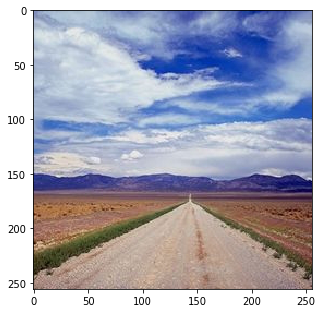

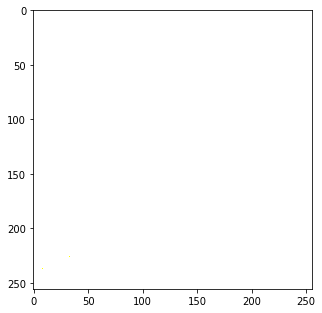

In [98]:
def return_model():
    model = colorization_deploy_v1(T=0.38)
    model.load_state_dict(torch.load("./../../model_l2.pt"))
    model.eval()
    #model = torch.load("./../../model_l2.pt")
    return model

def plot(im, interp=False):
    f = plt.figure(figsize=(5,10), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')


img_rgb = Image.open("sun.jpg") 
plot(img_rgb)
model = return_model()
d = model.predict(img_rgb)
plot(d)

In [35]:
def plot(im, interp=False):
    f = plt.figure(figsize=(5,10), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

In [ ]:
img_rgb = Image.open("sun.jpg") 
plot(img_rgb)
model = return_model()
d = model.predict_rgb(img_rgb)

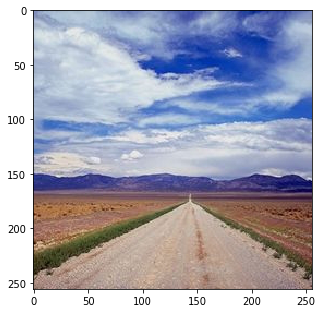

In [51]:
img_rgb = Image.open("sun.jpg")
plot(img_rgb)

In [65]:
img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.size[:2] # original image size

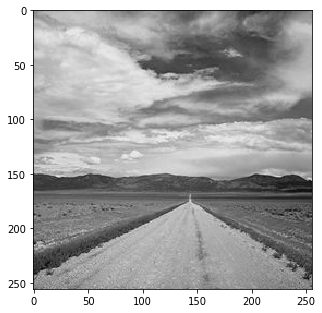

In [66]:
# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)
plot(img_rgb_bw)

In [69]:
mean_img_l = torch.as_tensor(img_l-50, dtype=torch.float32)
mean_img_l.unsqueeze_(0).unsqueeze_(0)
mean_img_l.shape

torch.Size([1, 1, 256, 256])

In [71]:
#gpu(model)
#mean_img_l = gpu(mean_img_l)
pred_ab = model(mean_img_l).squeeze(0)
d=pred_ab.cpu().detach().numpy().transpose((1,2,0))
print(d.shape)

(64, 64, 2)


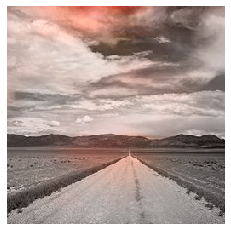

In [74]:
ab_dec_us = sni.zoom(d,(4,4,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');

In [83]:
from utils.data import ImageDataset
from torch.utils.data import DataLoader

list_best = [8528, 12441, 704, 15946, 8477, 16756, 8452, 7759, 13824, 8780]
list_worst = [2781, 146, 10152, 3399, 3397, 3396, 14832, 15020, 11616, 3395]

dataset = ImageDataset("./../Images")
dataloader = DataLoader(dataset, 1, False, num_workers=16)

plot(dataset.get_img(2))


AttributeError: 'ImageDataset' object has no attribute 'get_img'